## Loading all the needed packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/
!pip install colorednoise
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
from librosa import display

from IPython.display import Audio

# load our own python files
from pre_process import *
from data_loading import *
from Models import *
from Model_Functions import *

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4121, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 4121 (delta 189), reused 247 (delta 82), pack-reused 3722
Receiving objects: 100% (4121/4121), 685.38 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (774/774), done.
Checking out files: 100% (2810/2810), done.
/content/STAT3007_Project
  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3983 sha256=f4c74a8e306624d43f8cb2238a4e00171c99f5705aa5a35344ae8504580a3497
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


## Load Clean Data (run only this cell for clean data training and testing)

In [2]:
#Load the clean audio data
import scipy.io
mat = scipy.io.loadmat('/content/STAT3007_Project/jet.mat')
jet = mat['ans']
X,y = load_samples('/content/STAT3007_Project', padding = True, truncating = True, normal = True, duration = 2, Noisfy=False)
X = np.array(X)
# (batch_size, channels, freq, time)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])
RGB = Make_All_RGB(X,jet)
RGB = torch.tensor(RGB)
y = torch.tensor(y)

data_train, data_test = load_sets(RGB,y)[0]

## Load All Noisy Data (run only this cell for noisy data training and testing)

In [ ]:
#Import all the noisy data
noisy_data_train = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_train_RGB.npy')
noisy_data_test = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_test_RGB.npy')
noisy_targets_train = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_train_snr40.npy')
noisy_targets_test = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_test_snr40.npy')

noisy_data_train = torch.tensor(noisy_data_train)
noisy_data_test = torch.tensor(noisy_data_test)
noisy_targets_train = torch.tensor(noisy_targets_train)
noisy_targets_test = torch.tensor(noisy_targets_test)

wrapper_train = DatasetWrapper(noisy_data_train, noisy_targets_train)
wrapper_test = DatasetWrapper(noisy_data_test, noisy_targets_test)
data_train, data_test = wrapper_train, wrapper_test

# Training and Testing

In [ ]:
loss = nn.CrossEntropyLoss()
nepoch = 50
batch_size = 10
torch.manual_seed(69)
CNN = ConvNet(contain_linear = True, input_shape = (3,128,63))
trained_net, avg_loss, avg_acc, test_loss, test_acc = train_model(data_train,data_test, CNN, loss, nepoch = nepoch,lr = 0.001, batch_size = batch_size, use_cuda = True,print_output = False, momentum=0.4)
X_test, y_test = data_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
trained_net = trained_net.to(torch.device('cpu'))
y_pred = trained_net(X_test)
accuracy_score = accuracy(y_pred,y_test)
print('accuracy:' + str(accuracy_score))

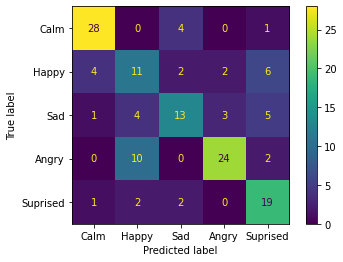

In [ ]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test, torch.argmax(y_pred, dim=1))
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot(values_format='.5g')

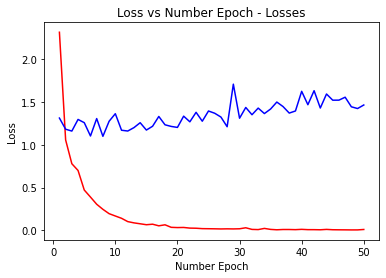

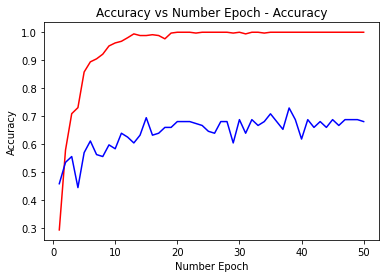

In [ ]:
plt.plot([x for x in range(1,nepoch+1)], avg_loss, 'r', [x for x in range(1,nepoch+1)], test_loss, 'b')
plt.xlabel("Number Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Number Epoch - Losses")
plt.show()
plt.plot([x for x in range(1,nepoch+1)], avg_acc, 'r', [x for x in range(1,nepoch+1)], test_acc, 'b')
plt.xlabel("Number Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number Epoch - Accuracy")
plt.show()